In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Binarizer
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from collections import Counter

Summary : 
    Define the sucess in order to categorize it : here 0 or 1 depending on a threshold (over 50,60,.. of popularity)
    Perform a GNB (for continous variables)
    Define the correctness : here since there are just a few 1 --> we define the accuracy by the number of right 1 
    problem : not enough one to learn 
    
 

# BAYES 

# Preprocessing

In [24]:
dfData=pd.read_csv("data.csv")
dataArtist=pd.read_csv("data_by_artist.csv",)
dataArtist=dataArtist[["artists","popularity"]]#on garde que la colonne artist et popularité 

#Traitement artists 
#on fait une liste d'artiste 
dfData["artists"]=dfData["artists"].str.replace("[","").str.replace("]","").str.replace("'",'').str.split(",")
dfData=dfData.explode("artists")


df=pd.merge(dfData,dataArtist,left_on="artists",right_on="artists")
df=df.rename(columns={"popularity_x":"popularity","popularity_y":"artistPop"})

df=df.drop_duplicates(subset=['id'])#on garde un artiste pour chaque titre et on lui associe une popularité 
df = df.sample(frac=1).reset_index(drop=True)
df.to_csv('popularitybyArtist.csv')
#la popularité DES artists d'une chanson : soit on fait une somme soit une moyenne 
#faire une groupe sur le titre + les autres variables 
print(df.head())
#print(merge.head())


   acousticness        artists  danceability  duration_ms  energy  explicit  \
0       0.00007       Ladytron         0.642       277867   0.794         0   
1       0.76200      Kate Bush         0.490       199227   0.362         0   
2       0.67300  Frank Sinatra         0.573       165933   0.198         0   
3       0.56500      Los Bukis         0.492       183667   0.532         0   
4       0.87600          alt-J         0.611       238747   0.413         0   

                       id  instrumentalness  key  liveness  loudness  mode  \
0  106R0orU4XC4tFbugFfRzT          0.348000    8    0.1460    -7.908     1   
1  6VpNGCU2ig4NQmsLfALdJU          0.000011    5    0.0671   -12.047     0   
2  55ueMwhsrlyXw06fjYZshX          0.000002    4    0.1040   -12.323     1   
3  0rSLIFKZbs4gSV8wPuIyRf          0.000000    7    0.1420    -9.835     1   
4  0pCTr2E9CtulIwNprituKi          0.022600    5    0.0799   -11.408     1   

                               name  popularity release_

**Classe : binariation de popularity en fonction d'un certain threshold**

In [10]:
df = df.sample(frac=1).reset_index(drop=True)
dfX=df[['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','year']] 
#dfy : devient est-ce que la  chanson a appartenu au top 100 ou non 
binarizer = Binarizer(threshold=70, copy=True)
df['popularity']=binarizer.fit_transform(df['popularity'].values.reshape(df.shape[0], 1))
#recup la colonne artist puis set, et mapping
#calculer la précision sur les data qui valent 1
dfy=df['popularity']
X=dfX.to_numpy()
y=dfy.to_numpy()
xTrain,xTest,yTrain,yTest=train_test_split(X,y,test_size=0.50,random_state=0)

**Nouvelle classe pour prédire le succès ou non : est ce que la musique fait partir du top 100?** 

In [25]:
# DataSet de départ : ici devient df 
#data = pd.read_csv("data.csv", encoding="iso-8859-1")

# DataSet des Top Hit (jusqu'à 2017)
top_songs = pd.read_csv("top_data.csv", encoding="iso-8859-1")

# On filtre donc notre DataSet de départ pour conserver seuelement les musiques avec date > 2017
data_2017 = df[df["year"]<2017]

# On recherche l'existence des musiques dans le DataSet des Hit Songs pour créer une nouvelle variable de succès 
data_2017["top"] = data_2017["name"].isin(top_songs["title"])
dfX=data_2017[['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','year']]
y=data_2017["top"].to_numpy()
X=dfX.to_numpy()
xTrain,xTest,yTrain,yTest=train_test_split(X,y,test_size=0.50,random_state=0)

<ipython-input-25-a91f4ab10557>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2017["top"] = data_2017["name"].isin(top_songs["title"])


# Oversampling

In [22]:
#oversampling 
print('Original data shape %s' % Counter(yTrain))
sm = SMOTE()
xTrain, yTrain = sm.fit_resample(xTrain, yTrain)
print('Resampled data shape %s' % Counter(yTrain))

Original data shape Counter({False: 69787, True: 10238})
Resampled data shape Counter({False: 69787, True: 69787})


# Undersampling

In [26]:
rus = RandomUnderSampler()
print('Original data shape %s' % Counter(yTrain))
xTrain, yTrain = rus.fit_sample(xTrain, yTrain)
print('Resampled data shape %s' % Counter(yTrain))

Original data shape Counter({False: 69709, True: 10316})
Resampled data shape Counter({False: 10316, True: 10316})


# Differenet Bayes

**BAYES with Scikit-lear**
*first try with a gaussian distribution: fit continuous data*
*NB : Gaussian Distribution, not pertinant
*sur-apprentissage ?*

Number of mislabeled points out of a total 80025 points : 34671
0.5667478912839737


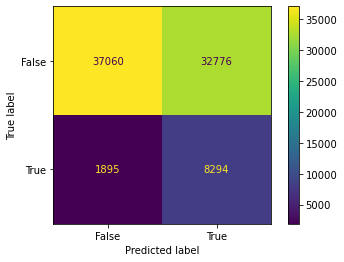

In [27]:
def GNB(xTrain,yTrain,xTest,yTest):
    gnb=GaussianNB()
    yPred=gnb.fit(xTrain,yTrain).predict(xTest)
    print("Number of mislabeled points out of a total %d points : %d"% (xTest.shape[0], (yTest != yPred).sum()))     
    print(metrics.accuracy_score(yTest, yPred))
    plot_confusion_matrix(gnb, xTest, yTest)
    plt.show()
    return yPred
yPred=GNB(xTrain,yTrain,xTest,yTest)
confMat = confusion_matrix(yTest, yPred)
#sns.jointplot(x=yTest, y=yPred, kind="kde", color="r")

**Right prediction on 1-values**

In [18]:
def OneCheck(yTest,yPred):
    yTest1,yPred1=[],[]  
    right1=0
    for i,test in enumerate(yTest):
        if test==1:
            yTest1.append(test)
            yPred1.append(yPred[i])
            if yPred[i]==1:
                right1+=1
    print("Right Prediction for sucess",right1/len(yTest1))
OneCheck(yTest,yPred)

Right Prediction for sucess 0.7948869223205507


What value of Popularity ? 

In [45]:

for pop in range(45,95,5):
    print(pop)
    df=pd.read_csv("data.csv")
    df = df.sample(frac=1).reset_index(drop=True)
    dfX=df[['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','year']]
    dfy=df['popularity']
    binarizer = Binarizer(threshold=pop, copy=True)
    df['popularity']=binarizer.fit_transform(df['popularity'].values.reshape(df.shape[0], 1))
    #recup la colonne artist puis set, et mapping
    #calculer la précision sur les data qui valent 1
    X=dfX.to_numpy()
    y=dfy.to_numpy()
    xTrain,xTest,yTrain,yTest=train_test_split(X,y,test_size=0.50,random_state=0)
    sm = SMOTE()
    xTrain, yTrain = sm.fit_resample(xTrain, yTrain)
    GNB(xTrain,yTrain,xTest,yTest)
    OneCheck(yTest,yPred)

45
Number of mislabeled points out of a total 84955 points : 18804
0.7786592902124654
Right Prediction for sucess 0.302825726644298
50
Number of mislabeled points out of a total 84955 points : 20719
0.7561179447943028
Right Prediction for sucess 0.3038513210927004
55
Number of mislabeled points out of a total 84955 points : 21931
0.7418515684774293
Right Prediction for sucess 0.2980533289710453
60
Number of mislabeled points out of a total 84955 points : 22552
0.7345418162556647
Right Prediction for sucess 0.3045639979602244
65
Number of mislabeled points out of a total 84955 points : 23744
0.7205108586898946
Right Prediction for sucess 0.3005438637975881
70
Number of mislabeled points out of a total 84955 points : 23642
0.7217114943205226
Right Prediction for sucess 0.31398416886543534
75
Number of mislabeled points out of a total 84955 points : 21415
0.7479253722559002
Right Prediction for sucess 0.29041095890410956
80
Number of mislabeled points out of a total 84955 points : 16569
0

**with scaling**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols=['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','year']
def scaleColumns(df, cols2Scale):
    for col in cols2Scale:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
    return df

dfScaled=scaleColumns(df,cols)
X=dfScaled[cols].to_numpy()
y=dfy.to_numpy()
xTrain,xTest,yTrain,yTest=train_test_split(X,y,test_size=0.25,random_state=0)
gnb=GaussianNB()
yPred=gnb.fit(xTrain,yTrain).predict(xTest)
print("Number of mislabeled points out of a total %d points : %d"% (xTest.shape[0], (yTest != yPred).sum()))
metrics.accuracy_score(yTest, yPred)*100


**with discretization & binarization**

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Binarizer
#first n bins and then one hot encoder
#discrete : mode
#let's do an ordinalEncoder : since variable are ordinal and not nominal 
#(ordered categories but the distance is not known)


disc = KBinsDiscretizer(n_bins=4, encode='uniform', strategy='uniform')
columns=df.columns.values.tolist()
cols=['acousticness','danceability', 'duration_ms', 'energy','instrumentalness',  'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

def Binarize(df,cols):
    long=df.shape[0]
    disc = KBinsDiscretizer(n_bins=3, encode='onehot', strategy='uniform')
    for c in cols:
        mean=df[c].mean()
        name=c+'Bin'
        binarizer = Binarizer(threshold=mean, copy=True)
        df[name]=binarizer.fit_transform(df[c].values.reshape(long, 1))
    return df


dfB=Binarize(df,cols)
print(dfB.head())

dfBX=dfB[['acousticnessBin','danceabilityBin','energyBin','instrumentalnessBin','livenessBin','loudnessBin','speechinessBin','tempoBin','valenceBin']][:1000]
#dfDX=dfD[['acousticnessDisc','danceabilityDisc','energyDisc','instrumentalnessDisc','livenessDisc','loudnessDisc','speechinessDisc','tempoDisc','valenceDisc']]
dfBy=df['popularity'][:1000]
XB=dfBX.to_numpy()
yB=dfBy.to_numpy()
xBTrain,xBTest,yBTrain,yBTest=train_test_split(XB,yB,test_size=0.50,random_state=0)


   acousticness                                            artists  \
0     -0.045706                  ['Steve Wariner', 'Garth Brooks']   
1     -1.299841                                     ['Humble Pie']   
2      1.284527  ['Johann Sebastian Bach', 'Amsterdam Toonkunst...   
3     -0.744011                                     ['Tom Browne']   
4     -0.831631                                      ['Aerosmith']   

   danceability  duration_ms    energy  explicit                      id  \
0      1.544668    -0.850460  0.218434         0  4bjKZrfowKmAfzHrRhpfcQ   
1     -1.506455    -0.386899  0.173556         0  6KL9kMRMmevqkJNnaVOeCJ   
2     -2.282067    -0.910911 -0.551979         0  2PbDTYjEz0AWyNiumrr22n   
3      0.575153    -0.080498  0.248353         0  3Yahrb4joLsIIdUSqyHJZ4   
4     -1.152867     0.538460  1.811618         0  2pg89WdhaUgJzVX3YobOht   

   instrumentalness  key  liveness  ...  acousticnessBin  danceabilityBin  \
0         -0.523507    9 -0.919650  ...      

**Bayes with SKlearn & binarized values**

In [6]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
yBPred=clf.fit(xBTrain, yBTrain).predict(xBTest)
print("Number of mislabeled points out of a total %d points : %d"% (xBTest.shape[0], (yBTest != yBPred).sum()))
metrics.accuracy_score(yBTest, yBPred)*100

Number of mislabeled points out of a total 500 points : 1


99.8

In [7]:
#apprenticeship issues : too many data not varied 